<a href="https://colab.research.google.com/github/cweikucf/cap4630/blob/master/HW_4/ConnerWeik_CAP4630_Homework4_Problem3_Classifier2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conner Weik
# CAP 4630, Spring 2020
# Homework 4, Problem 3
# Classifier 2
If something doesn't work, please try doing run all or let me know. Thanks!

For both classifiers, I will be using InceptionV3 as the conv base, and I will be unfreezing the top 30 layers of the conv base, that is, the layer named batch_normalization_90 and all layers above it.

For this classifier, I will use the following layers, added in the following order:

Flatten()

Dense(64, activation='relu')

Dense(1, activation='sigmoid')


For both classifiers, I will be using 20 epochs for the pre-fine-tuning training and 20 epochs for the fine-tuning.

# Imports and stuff

In [0]:
import os
import zipfile
from keras.applications import InceptionV3
from keras import layers
from keras import models
from keras import optimizers
from google.colab import files


## Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

We will use here the convolutional base of the VGG16 model to extract the features. We will feed these features to a densely connected classifier with dropout. We will fine-tune some layers.

## Download the data

Download the example data as in the original notebook.



In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-04-22 03:44:00--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 2404:6800:4008:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   101MB/s    in 0.6s    

2020-04-22 03:44:01 (101 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Build network with InceptionV3 convolution base and custom densely connected layers

### Load the convolutional base

In [0]:
from keras.applications import InceptionV3

conv_base = InceptionV3(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

### Freeze the convolutional base

In [0]:
conv_base.trainable = False

### Concatenate the convolutional base and densely connected layers

In [0]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [0]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_6 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                1179712   
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 22,982,561
Trainable params: 1,179,777
Non-trainable params: 21,802,784
_________________________________________________________________


## Train the model end to end with frozen convolutional base

In [80]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/20
100/100 [==============================] - 25s 253ms/step - loss: 0.6094 - acc: 0.6555 - val_loss: 0.4785 - val_acc: 0.8860
Epoch 2/20
100/100 [==============================] - 20s 196ms/step - loss: 0.5208 - acc: 0.7355 - val_loss: 0.1002 - val_acc: 0.9230
Epoch 3/20
100/100 [==============================] - 20s 197ms/step - loss: 0.4877 - acc: 0.7510 - val_loss: 0.1829 - val_acc: 0.9260
Epoch 4/20
100/100 [==============================] - 20s 197ms/step - loss: 0.4587 - acc: 0.7775 - val_loss: 0.3802 - val_acc: 0.9250
Epoch 5/20
100/100 [==============================] - 20s 198ms/step - loss: 0.4237 - acc: 0.8030 - val_loss: 0.0573 - val_acc: 0.9340
Epoch 6/20
100/100 [==============================] - 20s 197ms/step - loss: 0.4525 - acc: 0.7865 - val_loss: 0.1310 - val_acc: 0.9270
Epoch 7/20
100/100 [==============================] - 20s 198ms/step - loss: 0.4158 - acc: 0.8015 - val_lo

## Display curves of loss and accuracy during training

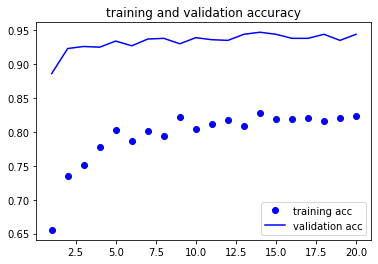

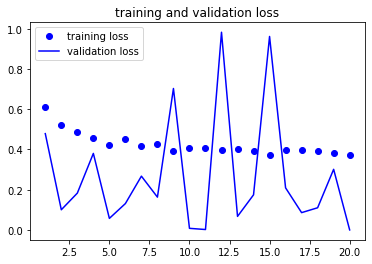

In [81]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Fine-tuning

## Show the layers of the network

In [82]:
for layer in conv_base.layers:
  print(layer.name)

input_6
conv2d_471
batch_normalization_471
activation_471
conv2d_472
batch_normalization_472
activation_472
conv2d_473
batch_normalization_473
activation_473
max_pooling2d_21
conv2d_474
batch_normalization_474
activation_474
conv2d_475
batch_normalization_475
activation_475
max_pooling2d_22
conv2d_479
batch_normalization_479
activation_479
conv2d_477
conv2d_480
batch_normalization_477
batch_normalization_480
activation_477
activation_480
average_pooling2d_46
conv2d_476
conv2d_478
conv2d_481
conv2d_482
batch_normalization_476
batch_normalization_478
batch_normalization_481
batch_normalization_482
activation_476
activation_478
activation_481
activation_482
mixed0
conv2d_486
batch_normalization_486
activation_486
conv2d_484
conv2d_487
batch_normalization_484
batch_normalization_487
activation_484
activation_487
average_pooling2d_47
conv2d_483
conv2d_485
conv2d_488
conv2d_489
batch_normalization_483
batch_normalization_485
batch_normalization_488
batch_normalization_489
activation_483
acti

I will be unfreezing the top 30 layers of the conv base, that is, the layer named batch_normalization_90 and all layers above it.

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'batch_normalization_90':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [0]:
# compile model

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/20
100/100 [==============================] - 28s 282ms/step - loss: 0.3778 - acc: 0.8310 - val_loss: 0.0029 - val_acc: 0.9100
Epoch 2/20
100/100 [==============================] - 21s 213ms/step - loss: 0.3429 - acc: 0.8405 - val_loss: 0.2064 - val_acc: 0.8900
Epoch 3/20
100/100 [==============================] - 21s 214ms/step - loss: 0.3630 - acc: 0.8345 - val_loss: 0.5141 - val_acc: 0.8840
Epoch 4/20
100/100 [==============================] - 22s 221ms/step - loss: 0.3781 - acc: 0.8255 - val_loss: 0.0882 - val_acc: 0.8760
Epoch 5/20
100/100 [==============================] - 22s 221ms/step - loss: 0.3747 - acc: 0.8240 - val_loss: 0.1343 - val_acc: 0.8700
Epoch 6/20
100/100 [==============================] - 22s 217ms/step - loss: 0.3650 - acc: 0.8350 - val_loss: 0.3187 - val_acc: 0.8710
Epoch 7/20
 67/100 [===================>..........] - ETA: 5s - loss: 0.3616 - acc: 0.8366

## Display learning curves during fine-tuning

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Print out validation loss and accuracy

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [0]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

# Results and deciding on the classifier

(1) My classifier 1 has the following layers, added in the following order:

Flatten()

Dense(256, activation='relu')

Dense(4, activation='relu')

Dense(1, activation='sigmoid')

Classifier 1 results:

Validation loss: 0.29284992814064026

Validation accuracy: 0.8700000047683716

![](https://drive.google.com/uc?id=1HUevm4GCy2bEtecaBl4mOEraO2kyMpwn)

(2) One version of classifier 2 had the following layers, added in the following order:

Flatten()

Dense(2048, activation='relu')

Dense(1, activation='sigmoid')

And the results

Validation loss: 0.8551866412162781

Validation accuracy: 0.8960000276565552

![](https://drive.google.com/uc?id=19UhgI8L66Em4uDRx_qWG0p9T2Z6zWTBj)

This had really high validation loss! The validation accuracy was also higher than (1).

(3)

Another version of classifier 2. This had the following layers added in the following order:

Flatten()

Dense(256, activation='relu')

Dense(64, activation='relu')

Dense(16, activation='relu')

Dense(4, activation='relu')

Dense(1, activation='sigmoid')

And the results

Validation loss: 0.2575221359729767
Validation accuracy: 0.8840000033378601

![](https://drive.google.com/uc?id=1EwsuVAoGfo8JuNYsFMzjEhaPg1yANNtS)

(4)

The current model. It has the following layers added in the following order:

Flatten()

Dense(64, activation='relu')

Dense(1, activation='sigmoid')

And the following results:

Validation loss: 0.34529033303260803

Validation accuracy: 0.8980000019073486

![](https://drive.google.com/uc?id=1F8BHxCbJssL63cHhR8K8D8-OflnJiuXx)

This has the highest accuracy so far! While its loss isn't the lowest, it's not bad compared to the others.
For the given dataset, maybe 64 parameters is good for a dense layer, and it would be good not to have too many layers or too many parameters.

The graphs for this one make the training and validation accuracy seem way more different than they actually are. The validation accuracy tended to be somewhat higher than the training accuracy to a non-extreme degree.